In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
from sklearn.datasets import load_sample_image

china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])

In [3]:
def plot_image(image):
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.axis('off')
    
def plot_color_image(image):
    plt.imshow(image, interpolation='nearest')
    plt.axis('off')

In [4]:
model = keras.applications.resnet50.ResNet50(weights='imagenet')

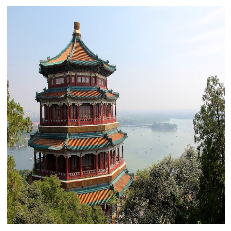

In [5]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


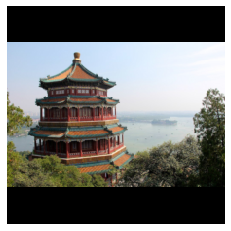

In [6]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])
plt.show()

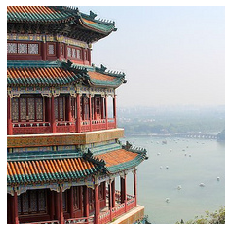

In [7]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

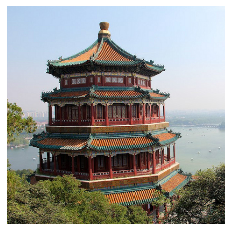

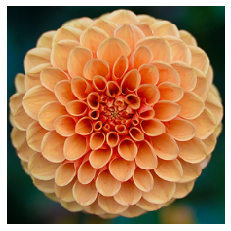

In [8]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [9]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
y_proba = model.predict(inputs)
y_proba.shape

(2, 1000)

In [10]:
top_k = keras.applications.resnet50.decode_predictions(y_proba, top=3)

for image_index in range(len(images)):
    print(f'Image #{image_index}')
    for class_id, name, y_proba in top_k[image_index]:
        print(f'  {class_id} - {name:12s} {y_proba * 100:.2f}%')
    print()

Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.08%
  n03781244 - monastery    11.69%

Image #1
  n04522168 - vase         53.97%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.96%

